In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
train_data = pd.read_csv('./hull-tactical-market-prediction/train.csv')
test_data = pd.read_csv('./hull-tactical-market-prediction/test.csv')

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nTrain data columns:", train_data.columns.tolist())
print("\nFirst few rows of train data:")
train_data.head()

Train data shape: (9021, 98)
Test data shape: (10, 99)

Train data columns: ['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P1', 'P10', 'P11', 'P12', 'P13', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S11', 'S12', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'V1', 'V10', 'V11', 'V12', 'V13', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

First few rows of train data:


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [4]:
# Check for missing values
print("Missing values in train data:")
print(train_data.isnull().sum().sum())
print("\nMissing values in test data:")
print(test_data.isnull().sum().sum())

# Display target variable statistics
print("\n=== Target Variable Statistics ===")
print(train_data['market_forward_excess_returns'].describe())

Missing values in train data:
137675

Missing values in test data:
0

=== Target Variable Statistics ===
count    9021.000000
mean        0.000053
std         0.010558
min        -0.040582
25%        -0.004747
50%         0.000255
75%         0.005479
max         0.040551
Name: market_forward_excess_returns, dtype: float64


In [5]:
# Prepare features and target
# Define feature groups based on column prefixes
feature_prefixes = ['D', 'E', 'I', 'M', 'P', 'S', 'V']

# Get all feature columns
feature_cols = [col for col in train_data.columns 
                if any(col.startswith(prefix) for prefix in feature_prefixes)]

print(f"Number of features: {len(feature_cols)}")

# Target variable
target_col = 'market_forward_excess_returns'

# Separate features and target for training data
X_train_full = train_data[feature_cols].copy()
y_train_full = train_data[target_col]

# Check which features have too many missing values
missing_pct = X_train_full.isnull().sum() / len(X_train_full) * 100
print(f"\nFeatures with >50% missing values: {(missing_pct > 50).sum()}")
print(f"Features with <50% missing values: {(missing_pct <= 50).sum()}")

# Use median imputation for features with some data, 0 for mostly empty features
for col in feature_cols:
    if missing_pct[col] > 90:
        X_train_full[col].fillna(0, inplace=True)
    else:
        median_val = X_train_full[col].median()
        X_train_full[col].fillna(median_val if not pd.isna(median_val) else 0, inplace=True)

print(f"\nX_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")
print(f"Remaining missing values: {X_train_full.isnull().sum().sum()}")

Number of features: 94

Features with >50% missing values: 8
Features with <50% missing values: 86

X_train shape: (9021, 94)
y_train shape: (9021,)
Remaining missing values: 0


In [6]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 7216
Validation set size: 1805


In [7]:
# Train XGBoost model
print("Training XGBoost model...")

xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_alpha': 0.01,
    'reg_lambda': 1.0,
    'random_state': 42,
    'tree_method': 'hist'
}

model = xgb.XGBRegressor(**xgb_params)

# Train with evaluation
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

print(f"\nModel training completed!")
print(f"Number of boosting rounds: {model.n_estimators}")

Training XGBoost model...
[0]	validation_0-rmse:0.01055	validation_1-rmse:0.01047
[100]	validation_0-rmse:0.00887	validation_1-rmse:0.01047
[200]	validation_0-rmse:0.00778	validation_1-rmse:0.01052
[300]	validation_0-rmse:0.00698	validation_1-rmse:0.01054
[400]	validation_0-rmse:0.00632	validation_1-rmse:0.01055
[500]	validation_0-rmse:0.00577	validation_1-rmse:0.01056
[600]	validation_0-rmse:0.00532	validation_1-rmse:0.01058
[700]	validation_0-rmse:0.00492	validation_1-rmse:0.01060
[800]	validation_0-rmse:0.00458	validation_1-rmse:0.01063
[900]	validation_0-rmse:0.00429	validation_1-rmse:0.01063
[999]	validation_0-rmse:0.00405	validation_1-rmse:0.01065

Model training completed!
Number of boosting rounds: 1000


In [8]:
# Evaluate model on validation set
y_pred_val = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print("=== Validation Set Performance ===")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² Score: {r2:.6f}")

=== Validation Set Performance ===
MSE: 0.000113
RMSE: 0.010649
MAE: 0.007639
R² Score: -0.035088


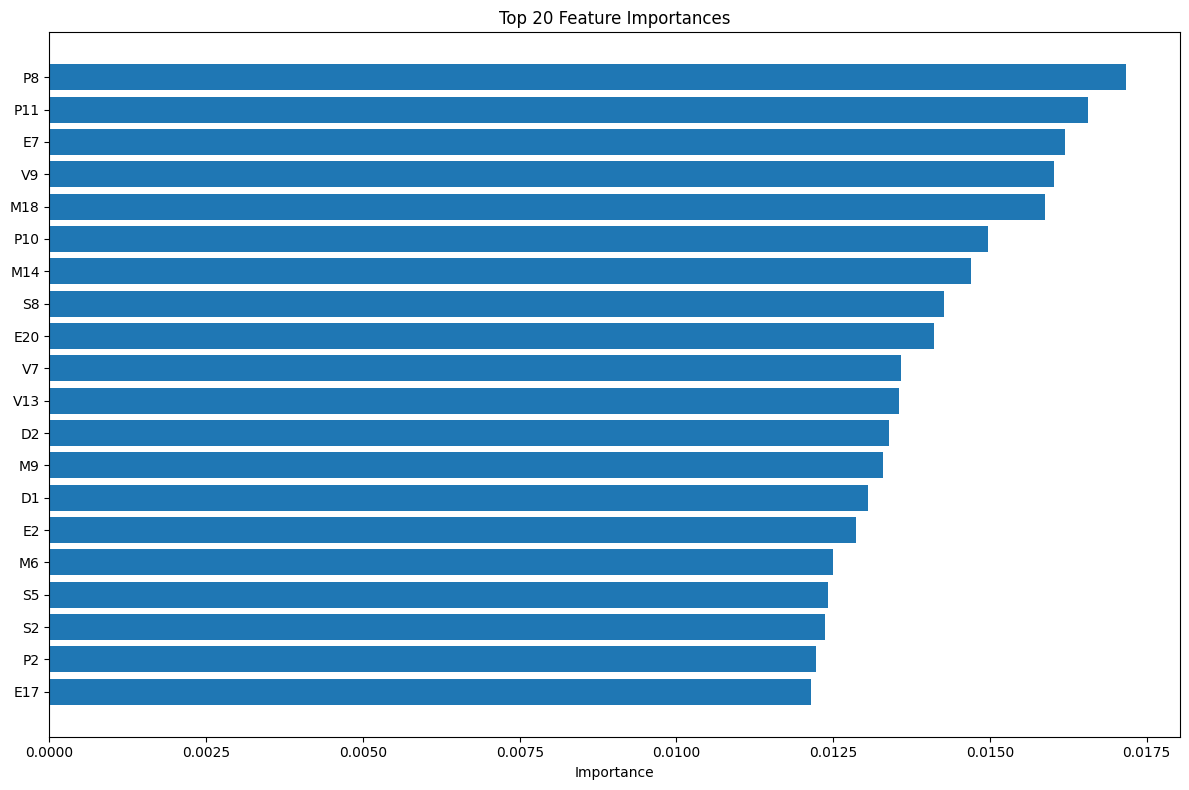


Top 10 most important features:
   feature  importance
67      P8    0.017173
58     P11    0.016566
26      E7    0.016194
93      V9    0.016016
47     M18    0.015879
57     P10    0.014965
43     M14    0.014702
79      S8    0.014265
21     E20    0.014111
91      V7    0.013588


In [9]:
# Plot feature importance
plt.figure(figsize=(12, 8))
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(importance_df.head(10))

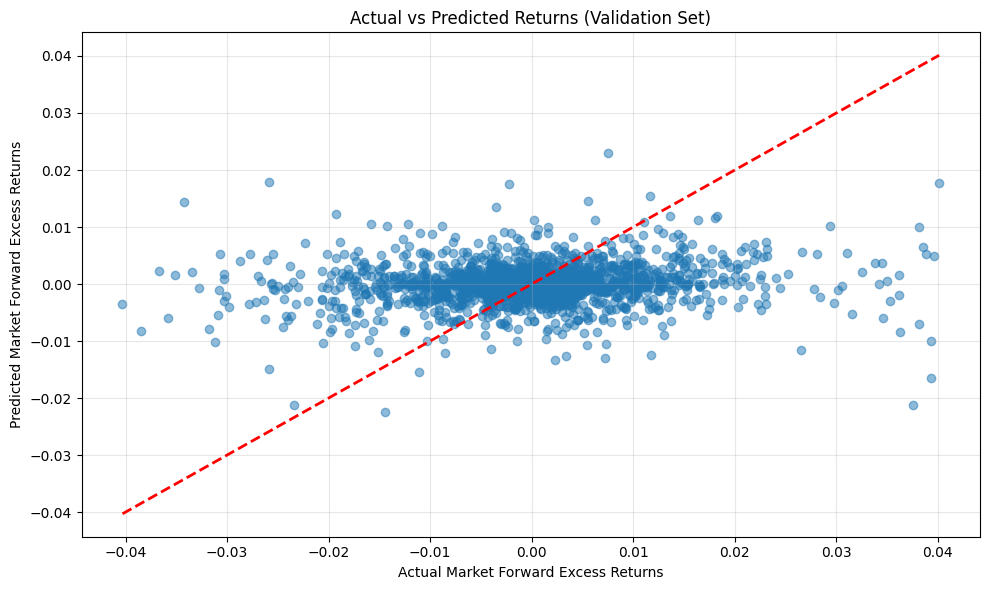

In [10]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Market Forward Excess Returns')
plt.ylabel('Predicted Market Forward Excess Returns')
plt.title('Actual vs Predicted Returns (Validation Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Make predictions on test set
# Filter only rows that need to be scored
test_scored = test_data[test_data['is_scored'] == True].copy()

print(f"Number of test samples to score: {len(test_scored)}")

# Prepare test features with same imputation strategy
X_test = test_scored[feature_cols].copy()

for col in feature_cols:
    if missing_pct[col] > 90:
        X_test[col].fillna(0, inplace=True)
    else:
        # Use training median for consistency
        train_median = X_train_full[col].median()
        X_test[col].fillna(train_median if not pd.isna(train_median) else 0, inplace=True)

print(f"Test missing values after imputation: {X_test.isnull().sum().sum()}")

# Make predictions
test_predictions = model.predict(X_test)

# Add predictions to test dataframe
test_scored['predicted_market_forward_excess_returns'] = test_predictions

print("\nTest predictions summary:")
print(pd.Series(test_predictions).describe())

# Display first few predictions
print("\nFirst 10 predictions:")
test_scored[['date_id', 'predicted_market_forward_excess_returns']].head(10)

Number of test samples to score: 9
Test missing values after imputation: 0

Test predictions summary:
count    9.000000
mean    -0.000192
std      0.002661
min     -0.004780
25%     -0.001177
50%     -0.000765
75%      0.001810
max      0.003406
dtype: float64

First 10 predictions:


,date_id,predicted_market_forward_excess_returns
0,8980,-0.003014
1,8981,-0.004780
2,8982,0.002268
3,8983,0.003406
4,8984,-0.000765
5,8985,-0.000946
6,8986,0.001810
7,8987,0.001469
8,8988,-0.001177


In [12]:
# Save predictions to CSV for submission
submission = test_scored[['date_id', 'predicted_market_forward_excess_returns']].copy()
submission.columns = ['date_id', 'market_forward_excess_returns']
submission.to_csv('submission.csv', index=False)

print("Predictions saved to submission.csv")
print(f"\nSubmission file shape: {submission.shape}")
submission.head(10)

Predictions saved to submission.csv

Submission file shape: (9, 2)


,date_id,market_forward_excess_returns
0,8980,-0.003014
1,8981,-0.004780
2,8982,0.002268
3,8983,0.003406
4,8984,-0.000765
5,8985,-0.000946
6,8986,0.001810
7,8987,0.001469
8,8988,-0.001177
